In [1]:
import os
import pandas as pd

Loading data from the folder

In [2]:
# Setting up path to load file
current_dir = os.getcwd()
csv_filename = 'data.csv'  
csv_path = os.path.join(current_dir, csv_filename)

# Initialize counter
bad_line_counter = 0

# Define a function to handle bad lines
def handle_bad_line(bad_line):
    global bad_line_counter
    bad_line_counter += 1
    return None  # Skip the bad line

# Read it in chunks due to huge size
chunk_size = 1_500_000

# Keep only relevant columns, remove ones with lots of NaN values
# LSOA name removed due to redundance
# Last outcome category removed due to high number of NaN values: 87 482 715 / 149 351 274 
# Context removed due to high number of NaN values: 144 750 473 / 149 351 274 
# Crime ID removed due to high number of NaN values: 5 781 005 / 27 205 384 (London)

columns_to_keep = ['Month', 'Latitude', 'Longitude', 'LSOA code', 'Crime type']
chunks = pd.read_csv(csv_path, 
                     chunksize=chunk_size,
                     usecols=columns_to_keep,
                     engine='python', 
                     on_bad_lines=handle_bad_line)

dfs = []
for i, chunk in enumerate(chunks):

    # Removing NaN values from certain columns
    # Coordinates because it is not possible to find out then if it is in london or not
    # LSOA because it is only 6 values from London, hard to later assign police officers
    chunk = chunk.dropna(subset=['Latitude', 'Longitude', 'LSOA code'])

    # Keep only rows inside London's coordinated obtained from Wikipedia
    lat_min, lat_max = 51.2867602, 51.6918741
    lon_min, lon_max = -0.5103751, 0.3340155

    chunk = chunk[
        (chunk['Latitude'] >= lat_min) & (chunk['Latitude'] <= lat_max) &
        (chunk['Longitude'] >= lon_min) & (chunk['Longitude'] <= lon_max)
    ]
    # Printing progress
    print(f"Processing chunk {i+1}...")
    dfs.append(chunk)

df_london = pd.concat(dfs, ignore_index=True)

print(f"Loaded {len(df_london)} good rows.")
print(f"Skipped {bad_line_counter} bad rows.")

Processing chunk 1...
Processing chunk 2...
Processing chunk 3...
Processing chunk 4...
Processing chunk 5...
Processing chunk 6...
Processing chunk 7...
Processing chunk 8...
Processing chunk 9...
Processing chunk 10...
Processing chunk 11...
Processing chunk 12...
Processing chunk 13...
Processing chunk 14...
Processing chunk 15...
Processing chunk 16...
Processing chunk 17...
Processing chunk 18...
Processing chunk 19...
Processing chunk 20...
Processing chunk 21...
Processing chunk 22...
Processing chunk 23...
Processing chunk 24...
Processing chunk 25...
Processing chunk 26...
Processing chunk 27...
Processing chunk 28...
Processing chunk 29...
Processing chunk 30...
Processing chunk 31...
Processing chunk 32...
Processing chunk 33...
Processing chunk 34...
Processing chunk 35...
Processing chunk 36...
Processing chunk 37...
Processing chunk 38...
Processing chunk 39...
Processing chunk 40...
Processing chunk 41...
Processing chunk 42...
Processing chunk 43...
Processing chunk 44.

Printing head to see the Data Frame

In [3]:
df_london.head()

,Month,Longitude,Latitude,LSOA code,Crime type
0,2010-12,0.165776,51.5442,E01000036,Anti-social behaviour
1,2010-12,0.165776,51.5442,E01000036,Anti-social behaviour
2,2010-12,0.165776,51.5442,E01000036,Violent crime
3,2010-12,0.165776,51.5442,E01000036,Violent crime
4,2010-12,0.165776,51.5442,E01000036,Violent crime


Counting NaN values 

In [4]:
def count_nans(df):
    """
    Count NaN values in each column of a df object
    Input:
    - df: df object obtained from data
    Returns:
    - dictionary with numbers of NaN values for each column
    """
    nan_counts = df.isna().sum().to_dict()
    return nan_counts

count_nans(df_london)

{'Month': 0, 'Longitude': 0, 'Latitude': 0, 'LSOA code': 0, 'Crime type': 0}

Data exploration space

In [5]:
# # Checking certain column's unique values
column_name = 'Falls within'
counts = df_london[column_name].value_counts(dropna=False).to_dict()
len(counts)

KeyError: 'Falls within'

In [58]:
# Check length
len(df_london)

27205378

In [59]:
# # Check where 'Reported by' and 'Falls within' are different
different_rows = df_london[df_london['Reported by'] != df_london['Falls within']]

# # Print how number of different rows
len(different_rows)

In [60]:
# # Select rows where 'Reported by' and 'Falls within' are different
different_rows = df_london[df_london['Reported by'] != df_london['Falls within']]

# # Create a dictionary: {Reported by : Falls within}
diff_dict = dict(zip(different_rows['Reported by'], different_rows['Falls within']))

# # Print results
print(diff_dict)


In [61]:
# # Removing Reported by column due to redundancy, every value that was 'Surrey Police' will now be 'City of London Police'
df_london = df_london.drop(columns=['Reported by'])
cleaned_london_data = df_london.rename(columns={'Falls within': 'Falls within/Reported by'})

Converting df into csv file for storage

In [ ]:
cleaned_london_data.to_csv('london_data.csv', index=False)

NameError: name 'cleaned_london_data' is not defined

SKIP HERE FOR ANALYSIS AND EXPLORATION OF CLEANED FILE

Loading new csv file and getting it ready for future work

In [65]:
import os
import pandas as pd
import matplotlib.pyplot as plt


In [4]:
# Get directory and path for the csv file
current_dir2 = os.getcwd()
csv_filename2 = 'london_data.csv'  
csv_path2 = os.path.join(current_dir2, csv_filename2)

df = pd.read_csv(csv_path2)
df.head()

,Month,Falls within/Reported by,Longitude,Latitude,Location,LSOA code,Crime type
0,2010-12,British Transport Police,0.165776,51.5442,On or near Dagenham East,E01000036,Anti-social behaviour
1,2010-12,British Transport Police,0.165776,51.5442,On or near Dagenham East,E01000036,Anti-social behaviour
2,2010-12,British Transport Police,0.165776,51.5442,On or near Dagenham East,E01000036,Violent crime
3,2010-12,British Transport Police,0.165776,51.5442,On or near Dagenham East,E01000036,Violent crime
4,2010-12,British Transport Police,0.165776,51.5442,On or near Dagenham East,E01000036,Violent crime


In [ ]:
df['Month'] = pd.to_datetime(df['Month'])
df_burglary = df[df['Crime type'] == 'Burglary']
monthly_trend = df_burglary.groupby(df_burglary['Month'].dt.to_period('M')).size()

# Plot the burglary trend
monthly_trend.plot(kind='line', title='Residential Burglary Trend in London', figsize=(12, 6))
plt.xlabel('Year')
plt.ylabel('Number of Crimes')
plt.grid(True)
plt.tight_layout()
plt.show()

top_locations = df_burglary['Location'].value_counts().head(10)
print("Top 10 Burglary Locations:\n", top_locations)


NameError: name 'df' is not defined

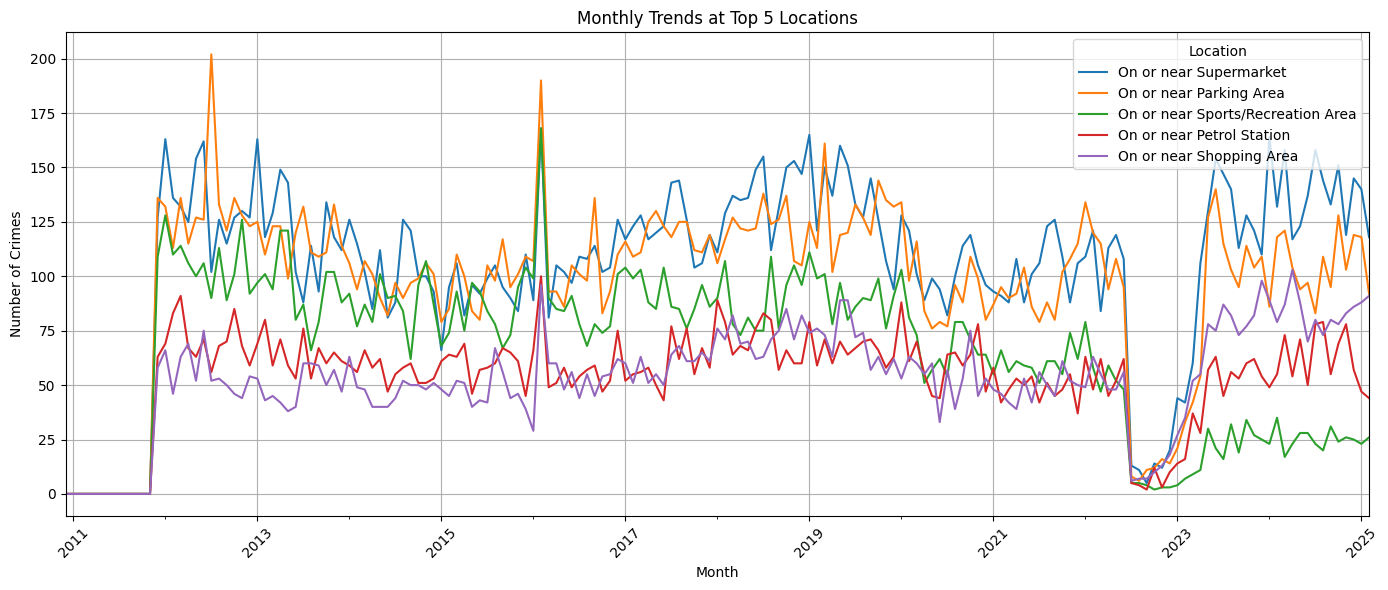

In [6]:
# Group by both Month and Location
burglary_by_location = df_burglary.groupby(['Month', 'Location']).size().reset_index(name='Crime count')

# Pivot to create a heatmap-style table
location_pivot = burglary_by_location.pivot(index='Month', columns='Location', values='Crime count').fillna(0)


top_5_locations = df_burglary['Location'].value_counts().head(5).index
location_pivot_top5 = location_pivot[top_5_locations]

# Plot trend for top 5 burglary locations
location_pivot_top5.plot(figsize=(14, 6))
plt.title('Monthly Trends at Top 5 Locations')
plt.xlabel('Month')
plt.ylabel('Number of Crimes')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.legend(title='Location')
plt.show()


C:\Users\mariz\AppData\Local\Temp\ipykernel_19664\4225007613.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_burglary['Month_num'] = df_burglary['Month'].dt.month
C:\Users\mariz\AppData\Local\Temp\ipykernel_19664\4225007613.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_burglary['Month_name'] = df_burglary['Month'].dt.month_name()


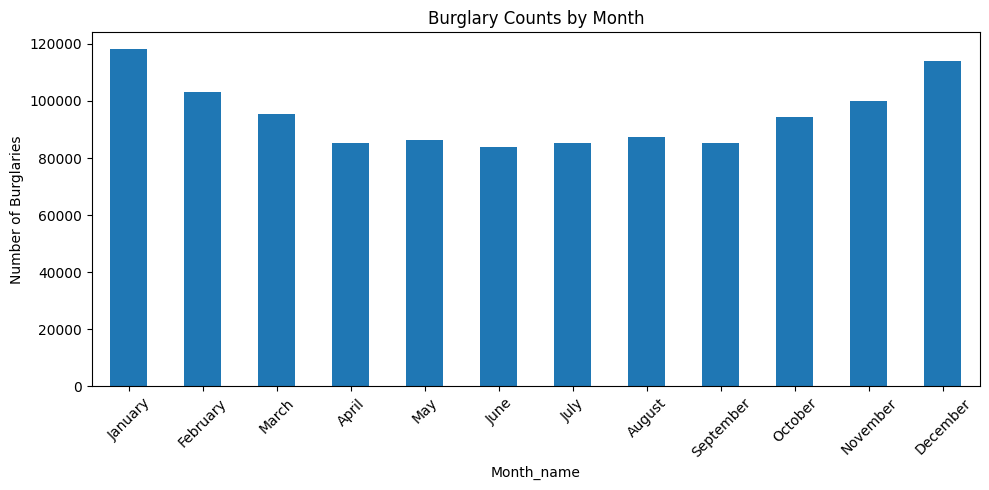

In [7]:
# Extract month and weekday from the date
df_burglary['Month_num'] = df_burglary['Month'].dt.month
df_burglary['Month_name'] = df_burglary['Month'].dt.month_name()

# Group by month
month_counts = df_burglary['Month_name'].value_counts().reindex([
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
])


#Monthly seasonality
month_counts.plot(kind='bar', title='Burglary Counts by Month', figsize=(10, 5))
plt.ylabel('Number of Burglaries')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\20231094\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
15:25:40 - cmdstanpy - INFO - Chain [1] start processing
15:25:40 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\20231094\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
C:\Users\20231094\AppData\Local\Temp\ipykernel_25492\3676144798.py:55: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\

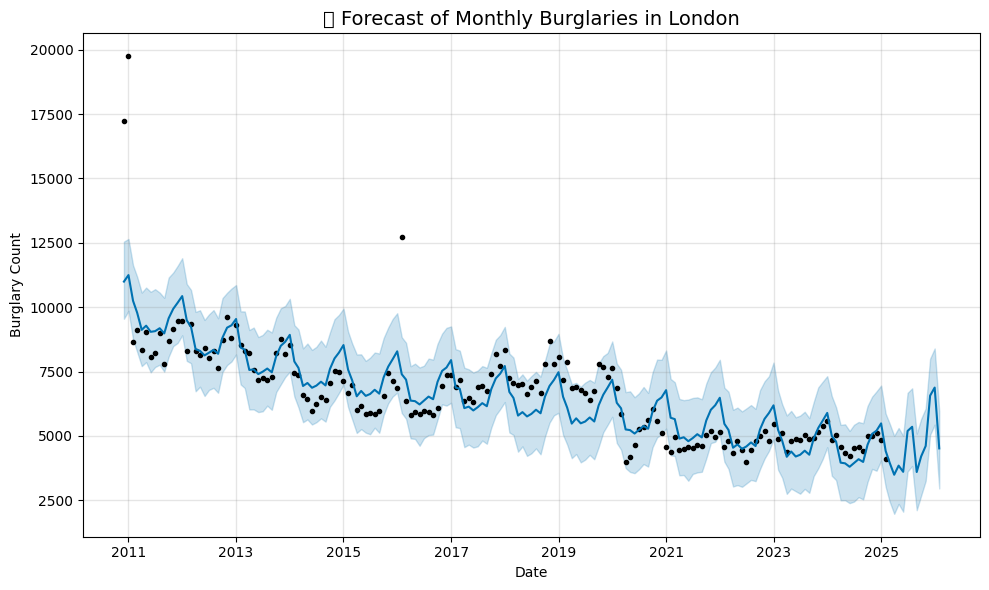

C:\Users\20231094\AppData\Local\Temp\ipykernel_25492\3676144798.py:61: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\20231094\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


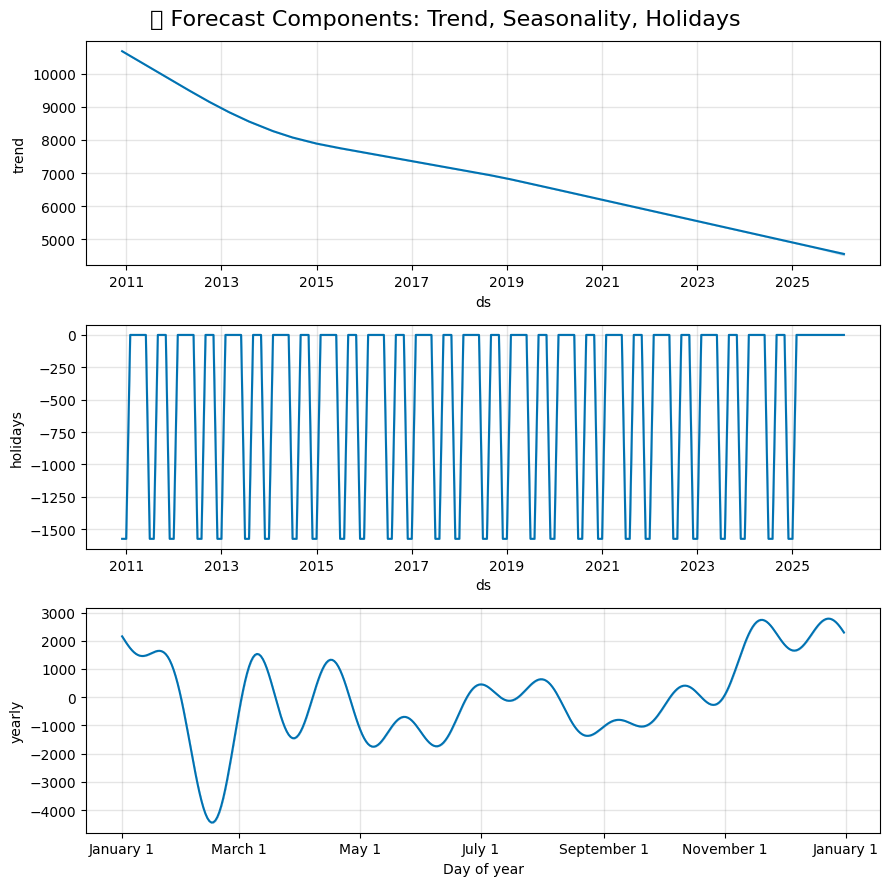


📌 Average forecasted burglaries in Jan, Jul, Aug, Dec by year:
year
2010    10994.785597
2011     9918.818382
2012     9076.746939
2013     8329.205360
2014     7807.038600
2015     7483.782812
2016     7212.770187
2017     6940.393948
2018     6692.993350
2019     6409.411097
2020     6077.481605
2021     5740.335901
2022     5430.650827
2023     5120.582762
2024     4787.829967
2025     5331.716519
2026     4517.978533
Name: yhat, dtype: float64


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet.plot import plot_plotly, plot_components_plotly


# Load cleaned CSV containing London crime data
csv_path = 'london_data.csv'  # Ensure this CSV exists in your working directory
df_london = pd.read_csv(csv_path)

# Convert 'Month' to datetime
df_london['Month'] = pd.to_datetime(df_london['Month'])

# Filter for burglary crimes
df_burglary = df_london[df_london['Crime type'] == 'Burglary'].copy()

# Prepare monthly time series data
df_monthly = (
    df_burglary
    .groupby(df_burglary['Month'].dt.to_period('M'))
    .size()
    .reset_index(name='y')
)
df_monthly['ds'] = df_monthly['Month'].dt.to_timestamp()
df_monthly = df_monthly[['ds', 'y']]

# Define holidays: December, January, July, August for each year
holiday_months = [1, 7, 8, 12]  # Jan, Jul, Aug, Dec
holiday_list = []

for year in range(df_monthly['ds'].dt.year.min(), df_monthly['ds'].dt.year.max() + 1):
    for month in holiday_months:
        holiday_list.append({
            'ds': pd.Timestamp(year=year, month=month, day=1),
            'holiday': 'holiday_month'
        })
df_holidays = pd.DataFrame(holiday_list)

# Initialize and fit Prophet
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=df_holidays
)
model.fit(df_monthly)

# Forecast next 12 months
future = model.make_future_dataframe(periods=12, freq='M')
forecast = model.predict(future)

# Plot forecast
fig1 = model.plot(forecast)
plt.title("📉 Forecast of Monthly Burglaries in London", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Burglary Count")
plt.tight_layout()
plt.show()

# Plot trend, seasonality, holidays
fig2 = model.plot_components(forecast)
plt.suptitle("📊 Forecast Components: Trend, Seasonality, Holidays", fontsize=16)
plt.tight_layout()
plt.show()

# Print average predicted burglaries in holiday months
forecast['month'] = forecast['ds'].dt.month
forecast['year'] = forecast['ds'].dt.year
forecast_holiday = forecast[forecast['month'].isin(holiday_months)]
avg_holiday_forecast = forecast_holiday.groupby('year')['yhat'].mean()
print("\n📌 Average forecasted burglaries in Jan, Jul, Aug, Dec by year:")
print(avg_holiday_forecast)
